In [1]:
import tensorflow as tf
import pandas as pd
from math import *
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from IPython.display import Image

### Preparing the data

In [2]:
dataset = pd.read_csv("data\StudentsPerformance.csv")
dataset = pd.get_dummies(dataset, 
               columns=["gender", "race/ethnicity", "parental level of education", "lunch", "test preparation course"],
               prefix=["gender", "race/ethnicity", "parental", "lunch", "preparation"])
dataset['final_score'] = dataset['math score'] + dataset['reading score'] + dataset['writing score']
dataset['final_score'] = dataset.final_score.map(lambda x: ceil(x))
dataset['pass'] = dataset.final_score.map(lambda x: 1 if x/3 > 70 else 0)

dataset_good = dataset[dataset['pass'] == 1]
dataset_bad = dataset[dataset['pass'] == 0]

In [3]:
print(dataset.shape, dataset_good.shape, dataset_bad.shape)

(1000, 22) (447, 22) (553, 22)


### Merging good & bad inputs

In [4]:
dataset_good['key'] = 0
dataset_bad['key'] = 0
df_1 = pd.merge(dataset_good, dataset_bad, on='key')
del df_1['key']

columns = df_1.columns.tolist()
reversed_columns = columns[22:] + columns[:22]
df_2 = df_1[reversed_columns]

In [5]:
print(df_1.shape, df_2.shape)

(247191, 44) (247191, 44)


In [6]:
list(df_1)

['math score_x',
 'reading score_x',
 'writing score_x',
 'gender_female_x',
 'gender_male_x',
 'race/ethnicity_group A_x',
 'race/ethnicity_group B_x',
 'race/ethnicity_group C_x',
 'race/ethnicity_group D_x',
 'race/ethnicity_group E_x',
 "parental_associate's degree_x",
 "parental_bachelor's degree_x",
 'parental_high school_x',
 "parental_master's degree_x",
 'parental_some college_x',
 'parental_some high school_x',
 'lunch_free/reduced_x',
 'lunch_standard_x',
 'preparation_completed_x',
 'preparation_none_x',
 'final_score_x',
 'pass_x',
 'math score_y',
 'reading score_y',
 'writing score_y',
 'gender_female_y',
 'gender_male_y',
 'race/ethnicity_group A_y',
 'race/ethnicity_group B_y',
 'race/ethnicity_group C_y',
 'race/ethnicity_group D_y',
 'race/ethnicity_group E_y',
 "parental_associate's degree_y",
 "parental_bachelor's degree_y",
 'parental_high school_y',
 "parental_master's degree_y",
 'parental_some college_y',
 'parental_some high school_y',
 'lunch_free/reduced_y',

In [7]:
#list(df_2)

### Splitting train & test set

In [8]:
abba = pd.concat([df_1, df_2], axis=1, join_axes=[df_1.index])
abba['first_better'] = 1

baab = pd.concat([df_2, df_1], axis=1, join_axes=[df_2.index])
baab['first_better'] = 0

baab.columns = abba.columns
both_sides = abba.append(baab, ignore_index=True)
both_sides.shape

(494382, 89)

In [9]:
train, test = train_test_split(both_sides, test_size=0.2)

left_train = train.iloc[:,:44]
left_test = test.iloc[:,:44]
right_train = train.iloc[:,44:88]
right_test = test.iloc[:,44:88]
y_train = train.iloc[:,88].reshape(-1,1)
y_test = test.iloc[:,88].reshape(-1,1)

print(left_train.shape, left_test.shape, right_train.shape, right_test.shape, y_train.shape, y_test.shape)

(395505, 44) (98877, 44) (395505, 44) (98877, 44) (395505, 1) (98877, 1)


### Neural Network

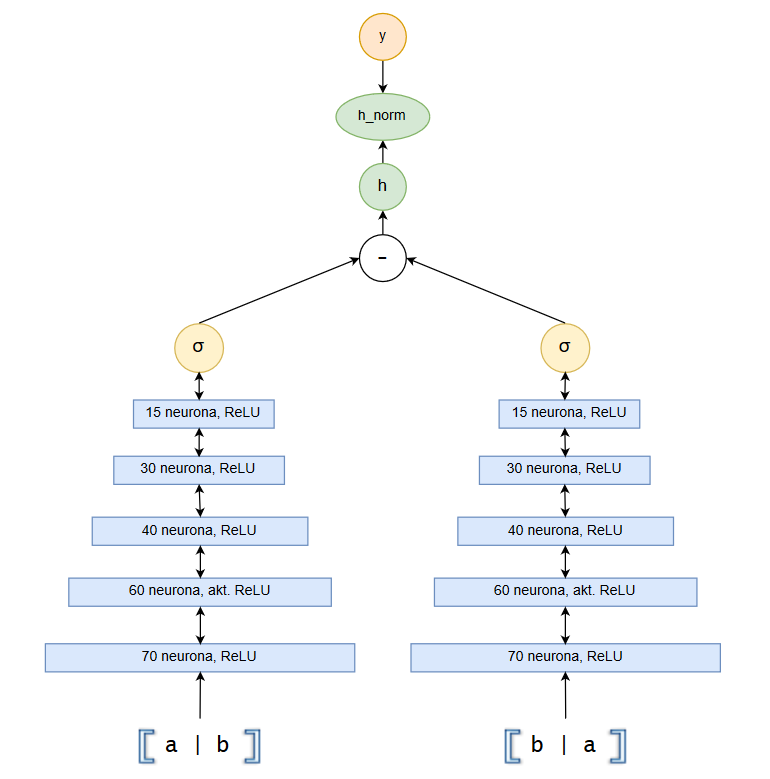

In [10]:
Image(filename="nn.png") 

In [11]:
def small_network(input_placeholder):
    layer_1 = tf.layers.dense(input_placeholder, 70, tf.nn.relu)
    layer_2 = tf.layers.dense(layer_1, 60, tf.nn.relu)
    layer_3 = tf.layers.dense(layer_2, 40, tf.nn.relu)
    layer_4 = tf.layers.dense(layer_3, 30, tf.nn.relu)
    layer_5 = tf.layers.dense(layer_4, 15, tf.nn.relu)
    output = tf.layers.dense(layer_5, 1, tf.nn.sigmoid)
    return output

In [12]:
tf.reset_default_graph()
input_left = tf.placeholder(tf.float32, shape=[None,left_train.shape[1]])
input_right = tf.placeholder(tf.float32, shape=[None,right_train.shape[1]])
output = tf.placeholder(tf.float32, shape=[None,1])

f_left = small_network(input_left)
f_right = small_network(input_right)
h = f_left - f_right

eps = 1e-11
h_norm = tf.div(tf.subtract(h, tf.reduce_min(h)), tf.maximum(tf.subtract(tf.reduce_max(h), tf.reduce_min(h)), eps))
loss = tf.losses.sigmoid_cross_entropy(output, h_norm)

### Train

In [14]:
lr = tf.placeholder(tf.float32)
train_op = tf.train.GradientDescentOptimizer(lr).minimize(loss)
num_epochs = 10
batch_size = 1551
num_batches = left_train.shape[0] // batch_size #255

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(num_epochs):
        print("Epoch {} / {}".format(epoch + 1, num_epochs))

        total_loss = 0.0
        for batch in range(num_batches):
            i = batch * batch_size
            j = (batch + 1) * batch_size         
            loss_, _ = sess.run([loss, train_op], feed_dict={input_left: left_train[i:j], input_right: right_train[i:j],
                                                                 output: y_train[i:j], lr: 0.0001})
            
            if batch % 50 == 0:
                print('---Batch %d/%d, batch loss %g' % (batch, num_batches, loss_))

Epoch 1 / 10
---Batch 0/255, batch loss 0.666188
---Batch 50/255, batch loss 0.663584
---Batch 100/255, batch loss 0.644989
---Batch 150/255, batch loss 0.643649
---Batch 200/255, batch loss 0.630418
---Batch 250/255, batch loss 0.62014
Epoch 2 / 10
---Batch 0/255, batch loss 0.614769
---Batch 50/255, batch loss 0.587751
---Batch 100/255, batch loss 0.575278
---Batch 150/255, batch loss 0.547948
---Batch 200/255, batch loss 0.538277
---Batch 250/255, batch loss 0.54037
Epoch 3 / 10
---Batch 0/255, batch loss 0.535745
---Batch 50/255, batch loss 0.523627
---Batch 100/255, batch loss 0.529294
---Batch 150/255, batch loss 0.516509
---Batch 200/255, batch loss 0.524416
---Batch 250/255, batch loss 0.530551
Epoch 4 / 10
---Batch 0/255, batch loss 0.525953
---Batch 50/255, batch loss 0.515824
---Batch 100/255, batch loss 0.522774
---Batch 150/255, batch loss 0.511473
---Batch 200/255, batch loss 0.520042
---Batch 250/255, batch loss 0.526992
Epoch 5 / 10
---Batch 0/255, batch loss 0.52243
--

### Test